In [1]:
import pandas as pd
import numpy as np
import random
from tqdm.notebook import trange

In [2]:
data = pd.read_csv('~/Downloads/out-4.csv', sep=';')

In [3]:
data.head()

,index,action,page_viewed_1,page_viewed_2,page_viewed_5,page_viewed_8,page_viewed_11,page_viewed_14,page_viewed_17,open_type_cookie,...,Q5_q5a3,click2button_click2link,like_dislike_like,system_favorite,system_share,like_dislike_dislike,system_optout_CREATIVE,like_dislike_unknown,session_start,session_end
0,0,page_viewed_1,0.000140,0.337617,0.015298,0.002896,0.000921,0.000414,0.000287,0.012463,...,0.000000,0.00000,0.000934,0.000360,0.000234,0.000100,0.000067,0.000020,0.0,0.451663
1,1,page_viewed_2,0.018916,0.000048,0.223665,0.021724,0.005337,0.001803,0.001694,0.003243,...,0.000000,0.00000,0.001573,0.000169,0.000182,0.000073,0.000036,0.000061,0.0,0.112190
2,2,page_viewed_5,0.002218,0.017871,0.000028,0.162100,0.022770,0.006500,0.002611,0.001979,...,0.000000,0.00000,0.000660,0.000140,0.000084,0.000070,0.000070,0.000112,0.0,0.052166
3,3,page_viewed_8,0.000755,0.003125,0.016982,0.000015,0.147815,0.025209,0.007336,0.001042,...,0.000030,0.00003,0.000302,0.000060,0.000075,0.000060,0.000060,0.000015,0.0,0.046132
4,4,page_viewed_11,0.000353,0.001106,0.003655,0.017745,0.000016,0.147888,0.025086,0.000866,...,0.001843,0.00008,0.000417,0.000048,0.000016,0.000032,0.000032,0.000048,0.0,0.034608


In [4]:
data = data.fillna(0)
data.drop(['index'], axis=1, inplace=True)
data = data.set_index('action')
data.replace([np.inf], 0, inplace=True)
data.loc['session_start', 'page_viewed_1'] = 1

In [5]:
data.head()

,page_viewed_1,page_viewed_2,page_viewed_5,page_viewed_8,page_viewed_11,page_viewed_14,page_viewed_17,open_type_cookie,page_viewed_7,Q5_q5a1,...,Q5_q5a3,click2button_click2link,like_dislike_like,system_favorite,system_share,like_dislike_dislike,system_optout_CREATIVE,like_dislike_unknown,session_start,session_end
action,,,,,,,,,,,,,,,,,,,,,
page_viewed_1,0.000140,0.337617,0.015298,0.002896,0.000921,0.000414,0.000287,0.012463,0.000093,0.000000,...,0.000000,0.00000,0.000934,0.000360,0.000234,0.000100,0.000067,0.000020,0.0,0.451663
page_viewed_2,0.018916,0.000048,0.223665,0.021724,0.005337,0.001803,0.001694,0.003243,0.000775,0.000024,...,0.000000,0.00000,0.001573,0.000169,0.000182,0.000073,0.000036,0.000061,0.0,0.112190
page_viewed_5,0.002218,0.017871,0.000028,0.162100,0.022770,0.006500,0.002611,0.001979,0.271949,0.000028,...,0.000000,0.00000,0.000660,0.000140,0.000084,0.000070,0.000070,0.000112,0.0,0.052166
page_viewed_8,0.000755,0.003125,0.016982,0.000015,0.147815,0.025209,0.007336,0.001042,0.001796,0.000257,...,0.000030,0.00003,0.000302,0.000060,0.000075,0.000060,0.000060,0.000015,0.0,0.046132
page_viewed_11,0.000353,0.001106,0.003655,0.017745,0.000016,0.147888,0.025086,0.000866,0.000112,0.011814,...,0.001843,0.00008,0.000417,0.000048,0.000016,0.000032,0.000032,0.000048,0.0,0.034608


In [6]:
# data.sum(axis=1)

In [7]:
def get_next_action(current_action, rnd):
    return data.columns[(rnd <= data.loc[current_action, :].cumsum()).argmax()]

def generate_logs(number_of_sessions=10):
    logs_data = pd.DataFrame(columns=['session', 'action', 'previous_action'])
    # Maybe you need to add 'date' column with random timestamp and random timedelta
    for session in trange(number_of_sessions):
        current_action = 'session_start'    
        logs_data = logs_data.append({'session': session, 
                                      'action': current_action,
                                      'previous_action': np.NAN}, ignore_index=True)
        while current_action != 'session_end':
            rnd = random.random()
            next_action = get_next_action(current_action, rnd)
            logs_data = logs_data.append({'session': session, 
                                          'action': next_action,
                                          'previous_action': current_action}, ignore_index=True)
            current_action = next_action
    return logs_data

In [9]:
logs_data = generate_logs(number_of_sessions=5 * 10**4)

In [35]:
def generate_graph_data(logs_data):
    tmp = logs_data.groupby(['previous_action', 'action']).count().reset_index()
    tmp = tmp.append({'previous_action':'session_end', 'action':'session_start', 'session': 0}, ignore_index=True) # костыль, чтобы добавить столбец session_start и строчку session_end
    result = tmp.pivot(index='previous_action', columns='action', values='session')
    result = result.fillna(0)
    return result

In [36]:
new_data = generate_graph_data(logs_data)

In [37]:
new_data

action,Q1_q1a1,Q1_q1a2,Q1_q1a3,Q2_q2a1,Q2_q2a2,Q2_q2a3,Q3_q3a1,Q3_q3a2,Q3_q3a3,Q4_q4a1,...,page_viewed_5,page_viewed_6,page_viewed_7,page_viewed_8,page_viewed_9,session_end,session_start,system_favorite,system_optout_CREATIVE,system_share
previous_action,,,,,,,,,,,,,,,,,,,,,
Q1_q1a1,0.0,11.0,0.0,18.0,24.0,2.0,1.0,3.0,1.0,0.0,...,48.0,0.0,0.0,9.0,0.0,13.0,0.0,0.0,0.0,0.0
Q1_q1a2,0.0,0.0,0.0,33.0,56.0,18.0,3.0,0.0,0.0,0.0,...,62.0,1.0,5.0,8.0,0.0,18.0,0.0,2.0,0.0,1.0
Q1_q1a3,1.0,6.0,0.0,13.0,24.0,4.0,2.0,1.0,0.0,1.0,...,39.0,0.0,2.0,3.0,0.0,21.0,0.0,0.0,0.0,1.0
Q2_q2a1,7.0,0.0,1.0,0.0,0.0,0.0,32.0,27.0,23.0,1.0,...,2850.0,2987.0,33.0,63.0,5.0,5.0,0.0,0.0,0.0,0.0
Q2_q2a2,2.0,4.0,1.0,21.0,0.0,0.0,38.0,32.0,19.0,2.0,...,4756.0,1.0,3966.0,101.0,4.0,19.0,0.0,0.0,0.0,0.0
Q2_q2a3,2.0,0.0,0.0,10.0,0.0,0.0,11.0,10.0,1.0,1.0,...,1455.0,2.0,1169.0,22.0,4.0,8.0,0.0,0.0,0.0,0.0
Q3_q3a1,1.0,1.0,1.0,1.0,1.0,0.0,0.0,15.0,1.0,34.0,...,6.0,5.0,6.0,3282.0,2.0,12.0,0.0,3.0,0.0,0.0
Q3_q3a2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.0,...,3.0,6.0,1.0,3448.0,3238.0,11.0,0.0,0.0,0.0,0.0
Q3_q3a3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.0,0.0,26.0,...,4.0,0.0,0.0,2122.0,0.0,8.0,0.0,0.0,0.0,0.0


In [39]:
new_data.to_csv('out.csv', sep=';')

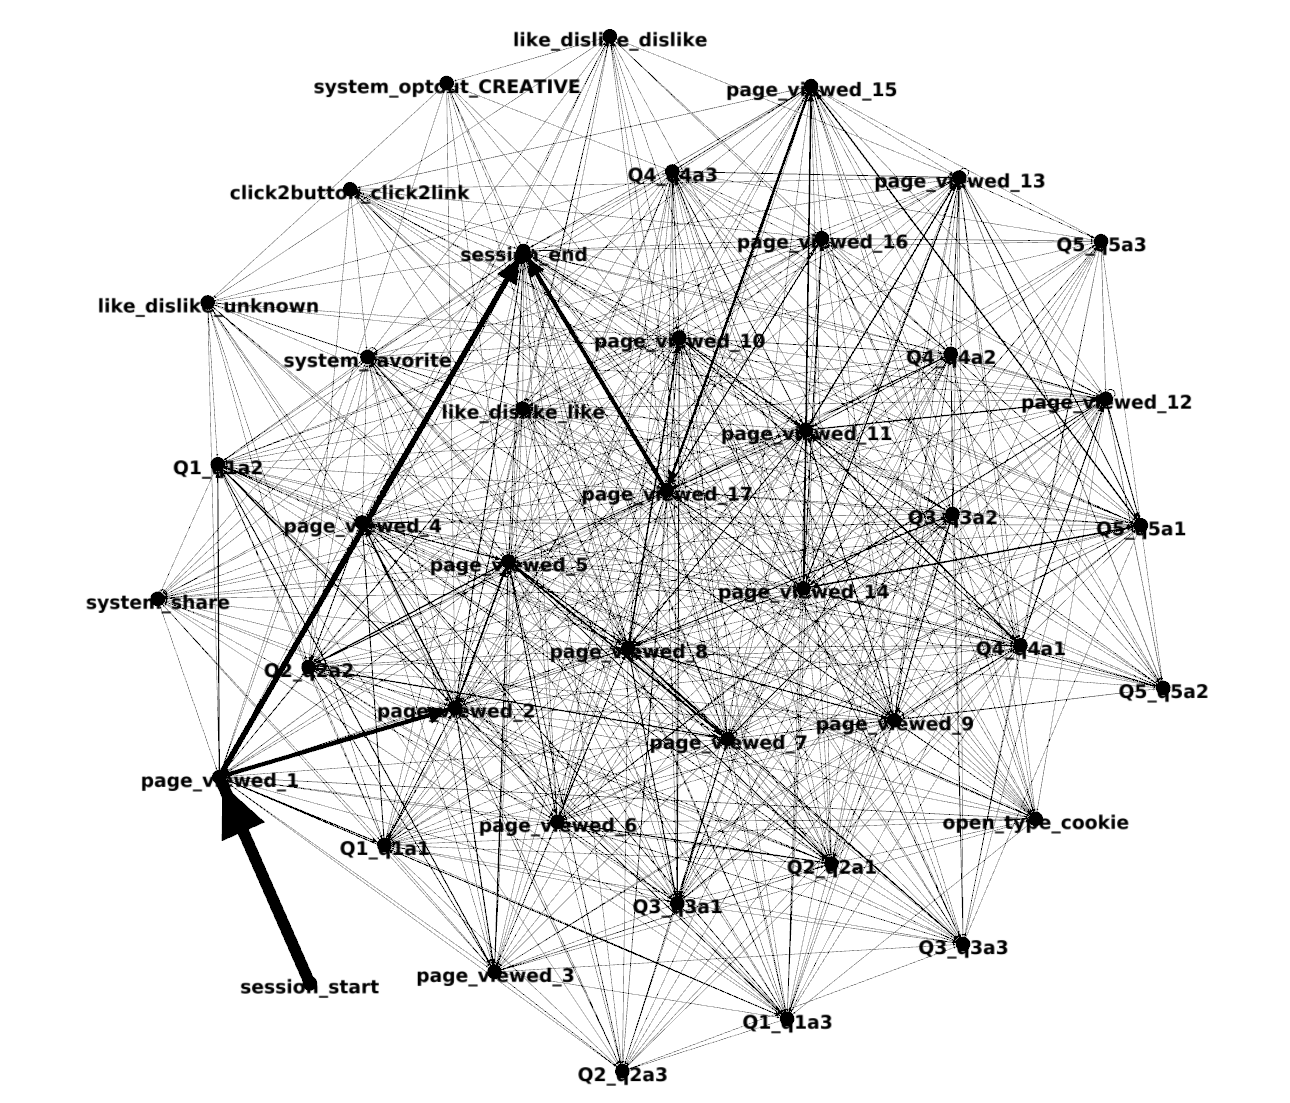

получилась вот такая вермишель